In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [4]:
# define filepath to read data
dir_path = '../CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [6]:
# drop unwanted columns based on Exploratory Data Analysis conducted earlier
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
# y_train = X_train.pop('RUL')  # pop RUL after dropping NaNs introduced by creating lagged variables

X_test_interim = test.drop(drop_labels, axis=1)

이 파일에서는 시계열 분석에 초점을 맞추자.   
1. 센서값 예측 및 알람 임계값 설정. 센서가 이 임계값을 넘을 것으로 예측되면 고장이 임박한 상태로 악화.  
그러나 CMAPSS에서는 주의사항이 있음.  
- 모든 센서는 개별적으로 모델링되어야하므로 센서 간 상호작용을 사용할 수 X
- 적절한 임계값을 설정하기 위해 많은 도메인 지식이 필요
- RUL 에 대해 직접 알려주지 않는다.


2. 벡터 자기회귀(VAR) 유형 모델은 다변수 시계열을 처리할 수 있지만  
모델은 초기에 X, Y 모두 지연을 생성한다.
일반적으로 시계열에서 Y의 과거값은 Y의 미래값을 결정하는 데 큰 역할을 한다.
그러나 Y에 대한 값이 train 세트에서 일정하거나 선형적으로 감소한다고 가정하기 때문에  
이러한 자체 정의된 목표를 모델에 통합하고 사용한다.  

예측의 경우 모델 결과에 큰 영향을 미치고 Yt에 대한 Yt-1의 영향을 과도하게 강조한다.  
지연된 Y 변수의 가중치에 대한 계수를 0으로 설정하는 사용자 정의 코드를 작성할 수 있지만  
더 쉬운 방법이 있다.

->
3. 분산 지연 모델. 기본적으로 각 변수에 추가하는 시차 수를 완전히 제어할 수 있는 회귀 모델이다.



우리가 구현할 모델 모습:  
Yt = a + B1*Xt + B2*Xt-1 + B3*Xt-2 ... + Bn*Xt-n  

절편은 a이고 계수는 B1~ 들이다. Xt-1 과 Xt-n은 Xt의 지연된 변수들이고  
Yt가 현재 시간 t에 대한 타겟 변수이다.  

만약 다음 사이클의 RUL Yt+1를 예측하고 싶다면 타겟을 한 번 지연시키면 된다..?

In [7]:
# 지연 변수 추가 - pandas의 shift 함수 사용
# lagged variables toy example
np.random.seed(42)
toy_df = pd.DataFrame({'value': np.random.rand(5)})
toy_df['value_lag_1'] = toy_df['value'].shift(1) # t+1
toy_df['value_lag_2'] = toy_df['value'].shift(2) # t+2 
display(toy_df)
# 결과를 보면 value가 한 time step?만큼 뒤로 밀렸다. 빈 부분에는 NaN이 들어가있다.

,value,value_lag_1,value_lag_2
0,0.374540,NaN,NaN
1,0.950714,0.374540,NaN
2,0.731994,0.950714,0.374540
3,0.598658,0.731994,0.950714
4,0.156019,0.598658,0.731994


In [8]:
# 지연 변수를 데이터셋에 적용해서 모델에 넣어보자
# 시차 변수를 추가한 결과 NaN 값이 도입된 행을 삭제하고 새 회귀 모델에 적용시킨다.
# create lagged variables
remaining_sensors = X_train.columns.difference(index_names+['RUL'])
lag1 = [col + '_lag_1' for col in remaining_sensors]

X_train[lag1] = X_train.groupby('unit_nr')[remaining_sensors].shift(1)
X_train.dropna(inplace=True)

X_test_interim[lag1] = X_test_interim.groupby('unit_nr')[remaining_sensors].shift(1)
X_test_interim.dropna(inplace=True)


# target variable
y_train = X_train.pop('RUL')

# 테스트 세트의 실제 RUL 값은 마지막 시간 주기 동안만 제공되므로 테스트 데이터 준비
X_test = X_test_interim.groupby('unit_nr').last().reset_index()

In [9]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [10]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:39.36769235113502, R2:0.6709929595362335
test set RMSE:31.4231098397042, R2:0.42820706786539353


In [11]:
# 시차를 추가하는 기능 - 1~n까지 시차 (t-1~t-n) 추가

def add_lagged_variables(df_input, nr_of_lags, columns):
    df = df_input.copy()
    for i in range(nr_of_lags):
        lagged_columns = [col + '_lag_{}'.format(i+1) for col in columns]
        df[lagged_columns] = df.groupby('unit_nr')[columns].shift(i+1)
    df.dropna(inplace=True)
    return df

In [12]:
# 특정 시차를 추가하는 기능 - 특정 시차만 추가(t-3, t-11 등)

def add_specific_lags(df_input, list_of_lags, columns):
    df = df_input.copy()
    for i in list_of_lags:
        lagged_columns = [col + '_lag_{}'.format(i) for col in columns]
        df[lagged_columns] = df.groupby('unit_nr')[columns].shift(i)
    df.dropna(inplace=True)
    return df

시계열 분석과 회귀 분석을 적용할 때 고려해야 할 가정이 있다.

### 1. 고정성 - Trend가 안 보이고 일정하게 oscilating만 하는 데이터가 없게끔?
정상성은 평균 및 분산과 같은 시계열의 통계적 속성이 시간이 지남에 따라 변경되지 않고  
공분산(시계열의 확산)이 시간에 종속되지 않아야 한다는 것을 의미한다.  

따라서 평균, 분산 또는 공분산이 시간에 따라 변경되면 모델은 다음 값을 정확하게 예측할 수 없다!!  

이러한 정상성을 확인하기 위해(테스트에 통과하지 못한 시계열을 정상으로 만드는 등..)  
Augmented Dickey Fuller 테스트를 사용한다.  

검정 통계량이 음수일수록 신호가 안정적이다. p value가 0.05 미만이면 시계열이 정상이라고 할 수 있다.

In [13]:
from statsmodels.tsa.stattools import adfuller

test_series = train.loc[train['unit_nr']==1, 's_7']
adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(test_series, maxlag=1)
print('single unit, single column test results')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}\n'.format(pvalue < 0.05))

single unit, single column test results
adf: -2.2766669279479737 
pvalue: 0.17960380425360056
Significant: False



In [14]:
test_series

0      554.36
1      553.75
2      554.26
3      554.45
4      554.00
        ...  
187    551.94
188    550.70
189    551.29
190    550.92
191    551.25
Name: s_7, Length: 192, dtype: float64

unit = 1, s_7값에 대해 adfuller를 적용해보았는데  
검정 통계량이 음수이긴 하지만 유의미하지는 않다.  
따라서 추세를 제거하고 다시 테스트 하기 위해 데이터를 한번 구별한다.

In [15]:
test_series = test_series.diff(1).dropna() # diff는 한 객체 내에서 열과 열 / 행과 행의 차이를 출력하는 메서드
# df.diff(periods=1, axis=0)
# axis : 비교할 축을 지정합니다. axis=0 인 경우 행끼리 비교하고 axis=1인 경우 열 끼리 비교합니다.
# periods : 비교할 간격을 지정합니다. 기본은 +1로 바로 이전 값과 비교합니다.
adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(test_series, maxlag=1)
print('single unit, single column test results after differencing')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}\n'.format(pvalue < 0.05))

single unit, single column test results after differencing
adf: -14.824168539718963 
pvalue: 1.9431018596392754e-27
Significant: True



훨씬 나은 p value가 달성되었다. 즉 정상적인 상태로 들어섰다.

이런 식으로 test를 진행해서 데이터가 정상인지 아닌지를 구별하는 걸 각 엔진의 각 센서에 대해  
몇 번 씩이나 더 해줘야할지 미리 알 수 없기 때문에 아래와 같은 함수들을 만든다.  
(정상성 체크에는 p value를 사용할 것)

In [16]:
# 정상인지 아닌지에 따라 추세를 제거하고 데이터를 구별할 것인지 말 것인지를 알아보기 위해
# diff 를 계산해서 정상성이 True가 되게끔 한다. pvalue<0.05일 때까지
def find_max_diff(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series.diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
    return maxdiff

# 각 unit_nr마다 정상성을 판별해서 테스트에 못 통과한 애들은? 데이터에서 구별함. dropna 
# 고정 데이터(stationary data)로 만드는 함수
def make_stationary(df_input, columns):
    df = df_input.copy()
    for unit_nr in range(1, df['unit_nr'].max()+1):
        for col in columns:
            maxdiff = find_max_diff(df.loc[df['unit_nr']==unit_nr, col])
            if maxdiff > 0:
                df.loc[df['unit_nr']==unit_nr, col] = df.loc[df['unit_nr']==unit_nr, col].diff(maxdiff)
    df.dropna(inplace=True)
    return df

In [17]:
# 위에서 만든 sensor stationary를 이용해 unit_nr마다 데이터들을 고정 상태로 만들어준다.
intermediate_df = train.drop(drop_labels, axis=1)
intermediate_df = make_stationary(intermediate_df, remaining_sensors)

intermediate_df.head()  # stationary data!

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
1,1,2,642.15,1591.82,2.54,-0.61,-0.02,9044.07,0.02,0.62,0.05,-7.13,8.4318,392.0,39.00,23.4236,190
2,1,3,642.35,1587.99,1.06,0.51,0.04,9052.94,-0.22,0.14,-0.04,1.74,8.4178,390.0,38.95,23.3442,189
3,1,4,642.35,1582.79,-2.33,0.19,0.03,9049.48,-0.14,0.44,0.05,0.60,8.3682,392.0,38.88,23.3739,188
4,1,5,642.37,1582.85,4.35,-0.45,-0.05,9055.15,0.15,-0.67,-0.04,-0.03,8.4294,393.0,38.90,23.4044,187
5,1,6,642.10,1584.47,-7.85,0.67,-0.04,9049.68,-0.12,-0.51,-0.01,-0.95,8.4108,391.0,38.98,23.3669,186


이렇게 데이터를 고정시켰으니 이제 다시 선형 회귀 모델에 fitting해보자

In [18]:
# create and fit model
lm = LinearRegression() # intermediate_df = 고정시킨 데이터
lm.fit(intermediate_df[remaining_sensors], intermediate_df['RUL'])

# predict and evaluate
y_hat_train = lm.predict(intermediate_df[remaining_sensors])
evaluate(intermediate_df['RUL'], y_hat_train, 'train')

train set RMSE:51.633756137911796, R2:0.43408640113852315


데이터를 고정적으로 만들었더니 RMSE 가 상당히 나빠졌다.  
-> 더 이상 추세가 없는 데이터가 되어 회귀선을 맞추기가 어렵다.  
하지만 지연 변수를 추가하면 시간 경과에 따른 센서 값의 변화 관계를 모델에 알려주므로  
성능은 다시 향상된다!  

이제 최적의 모델을 위해 추가해야 할 지연 시간을 결정하기 위해 검색을 해보자  
(아까 특정 시차를 추가할 건지.. 전체 시차를 추가할 건지 함수 만들었었다)

### 2. AIC (Akaike Information Criterion) : 정확한 시차 수 검색  
모델 품질을 반영하는 메트릭, 시계열 분석에 자주 사용됨.  
Overfitting, Underfitting을 모두 고려한다.  
여러 유사한 모델을 훈련할 때 모델 선택을 위해 AIC 점수를 비교할 수 있다.  

점수가 낮을수록 좋지만 복잡성 <-> 모델 품질 향상 사이에는 offset이 있다.  
0~n 까지의 지연이 있는(t~t-n) 일부 모델을 훈련하고 AIC를 계산하여 최고 품질의  
모델을 만들어보자!

In [19]:
# 최적의 지연 길이(lag length)를 찾기 위해 지연(lag)과 evaluate model을 추가한다.
import statsmodels.api as sm

metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(intermediate_df, i, remaining_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)

display(metrics)

,rmse,AIC,BIC
0,51.652627,220271.65,220390.59
1,46.060503,214530.30,214760.12
2,43.058562,210753.82,211094.38
3,41.151503,207898.35,208349.51
4,39.833453,205574.27,206135.89
5,38.813294,203528.00,204199.94
6,37.986450,201667.95,202450.06
7,37.304649,199952.23,200844.37
8,36.723366,198338.72,199340.76
9,36.198014,196782.37,197894.15


AIC에서 많은 지연을 추가함으로서 AIC 점수가 감소(모델 품질이 더 좋아짐)  
가 나타나는 전환점을 찾고자 한다!  
그런데 메트릭을 보면 꾸준히 개선되는 것처럼 보여서 어떤 지연을 추가해야 할지   
확실히 알기가 어렵다.. 플로팅을 한다.

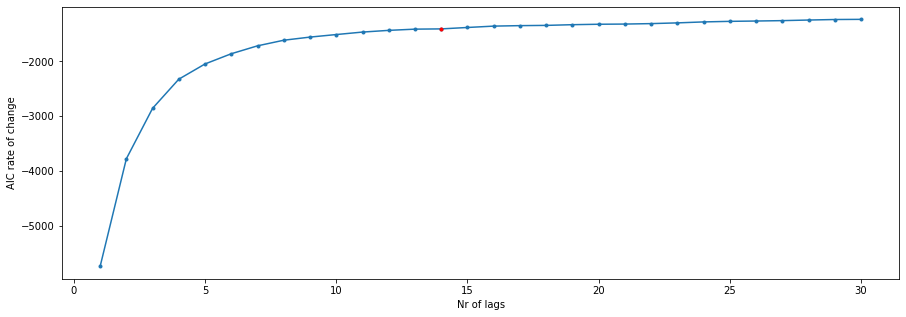

In [20]:
plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.plot(14, metrics['AIC'].diff()[14], '.r') # 전환점은 빨간색으로 표시
plt.xlabel("Nr of lags")
plt.ylabel("AIC rate of change")
plt.show()
plt.close()

보니까 14 시차 이후 거의 정체되는 것을 알 수 있다.  
그러므로 지연을 더 추가해도 더 이상 모델 성능이 좋아지지 않음을 나타내기 때문에  
14로 시차를 결정하는 것이 좋겠다.  

또한 동일한 변수의 여러 시차를 추가할 때는 다중 공선성이라는 걸 고려해야 한다.  

### 3. 다중 공선성  
다중회귀모형에서 독립변수가 높은 상관관계를 가질 때 발생.
이전 시점의 값이 다음 시점 값과 본질적으로 관련된 시계열의 특성으로 인해  
지연 변수를 추가할 때 다중 공선성이 발생할 가능성이 농후하다.  

다중 공선성은 모델의 계수, 안정성에 영향을 미치므로 새 데이터에서 잘못된 결과가  
나올 가능성이 높아진다.  

경험적으로 5 미만의 VIF(Variance Inflation Factor)는 안전하다고 간주되므로  
모델의 다중 공선성을 테스트하자.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
X_train = add_lagged_variables(intermediate_df, 14, remaining_sensors)
X_train = X_train.drop(index_names, axis=1)

# note, this takes a few minutes to calculate
vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

{'s_2': 4081069.37,
 's_3': 148827.31,
 's_4': 34450.38,
 's_7': 676636.48,
 's_8': 2591641803.36,
 's_9': 1580259.79,
 's_11': 28779.21,
 's_12': 686940.38,
 's_13': 2480791096.44,
 's_14': 1724157.4,
 's_15': 116497.33,
 's_17': 152527.42,
 's_20': 113760.29,
 's_21': 119734.69,
 'RUL': 5.11,
 's_11_lag_1': 36657.17,
 's_12_lag_1': 785930.67,
 's_13_lag_1': 2613853860.37,
 's_14_lag_1': 1926076.65,
 's_15_lag_1': 116696.91,
 's_17_lag_1': 152525.25,
 's_2_lag_1': 4074895.76,
 's_20_lag_1': 113444.5,
 's_21_lag_1': 119475.96,
 's_3_lag_1': 148979.81,
 's_4_lag_1': 38889.32,
 's_7_lag_1': 733701.46,
 's_8_lag_1': 2748462855.3,
 's_9_lag_1': 1716566.66,
 's_11_lag_2': 37805.01,
 's_12_lag_2': 780833.03,
 's_13_lag_2': 2620758747.64,
 's_14_lag_2': 1917277.53,
 's_15_lag_2': 116346.14,
 's_17_lag_2': 152686.28,
 's_2_lag_2': 4072573.42,
 's_20_lag_2': 113685.05,
 's_21_lag_2': 119653.41,
 's_3_lag_2': 149009.07,
 's_4_lag_2': 38847.79,
 's_7_lag_2': 730031.66,
 's_8_lag_2': 2753903979.86

엥 각 센서-lag 변수들이 상관관계를 이렇게 많이 가진다고..?  
5 보다 너무 큰 값을 가지고 있다.
하지만 아직 scaling을 적용하지 않아서 그런 것이다. 따라서
trian_df에 StandardScaler(스케일링- 예전에 말했던 데이터들의 스케일이 모두 다르면 100~110 이랑 10000~11000이랑의 차이를 줄임.)를 적용하자.  


In [25]:
# VIF를 줄이기 위해 Scaling을 적용.

from sklearn.preprocessing import StandardScaler

intermediate_df = train.drop(drop_labels, axis=1)
scaler = StandardScaler()
scaler.fit(intermediate_df[remaining_sensors])
intermediate_df[remaining_sensors] = scaler.transform(intermediate_df[remaining_sensors])

intermediate_df = make_stationary(intermediate_df, remaining_sensors)

X_train = add_lagged_variables(intermediate_df, 14, remaining_sensors)
X_train = X_train.drop(index_names, axis=1)

vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

{'s_2': 2.58,
 's_3': 2.31,
 's_4': 2.09,
 's_7': 2.21,
 's_8': 2.39,
 's_9': 4.15,
 's_11': 1.9,
 's_12': 1.97,
 's_13': 2.37,
 's_14': 4.75,
 's_15': 2.55,
 's_17': 2.47,
 's_20': 2.64,
 's_21': 2.72,
 'RUL': 2.34,
 's_11_lag_1': 2.39,
 's_12_lag_1': 2.22,
 's_13_lag_1': 2.47,
 's_14_lag_1': 5.27,
 's_15_lag_1': 2.51,
 's_17_lag_1': 2.42,
 's_2_lag_1': 2.54,
 's_20_lag_1': 2.59,
 's_21_lag_1': 2.67,
 's_3_lag_1': 2.27,
 's_4_lag_1': 2.32,
 's_7_lag_1': 2.36,
 's_8_lag_1': 2.51,
 's_9_lag_1': 4.48,
 's_11_lag_2': 2.42,
 's_12_lag_2': 2.18,
 's_13_lag_2': 2.45,
 's_14_lag_2': 5.22,
 's_15_lag_2': 2.47,
 's_17_lag_2': 2.39,
 's_2_lag_2': 2.49,
 's_20_lag_2': 2.55,
 's_21_lag_2': 2.63,
 's_3_lag_2': 2.24,
 's_4_lag_2': 2.29,
 's_7_lag_2': 2.31,
 's_8_lag_2': 2.48,
 's_9_lag_2': 4.42,
 's_11_lag_3': 2.35,
 's_12_lag_3': 2.13,
 's_13_lag_3': 2.42,
 's_14_lag_3': 5.14,
 's_15_lag_3': 2.43,
 's_17_lag_3': 2.35,
 's_2_lag_3': 2.45,
 's_20_lag_3': 2.53,
 's_21_lag_3': 2.59,
 's_3_lag_3': 2.2,


음 훨씬 VIF가 5 미만으로 낮아졌다!   
이제 모델 평가를 하기 위해 AIC를 다시 측정하고, 얼만큼의 시차를 적용하면 좋을지  
적용해보자. 아까 했던 AIC 검사와 plotting을 진행한다

In [26]:
# add lags and evaluate models to find optimal lag length
import statsmodels.api as sm

metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(intermediate_df, i, remaining_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)

display(metrics)

,rmse,AIC,BIC
0,45.311459,214892.78,215011.72
1,43.199826,211909.99,212139.82
2,42.321539,210051.72,210392.28
3,41.806392,208537.26,208988.42
4,41.449199,207175.30,207736.92
5,41.159315,205879.37,206551.31
6,40.908577,204622.43,205404.54
7,40.677353,203385.46,204277.60
8,40.459553,202162.57,203164.60
9,40.246294,200945.11,202056.89


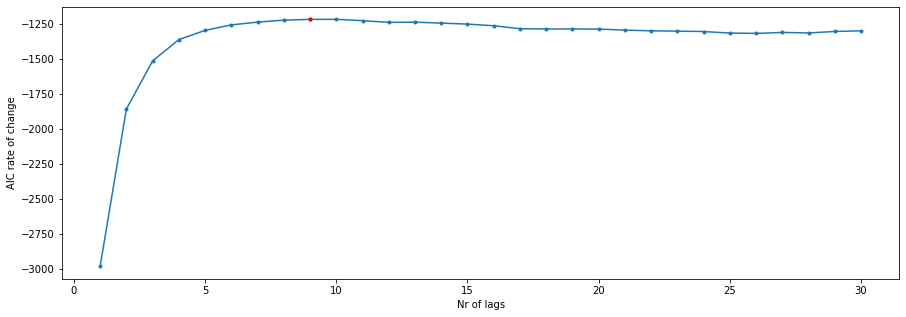

In [28]:

plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.plot(9, metrics['AIC'].diff()[9], '.r')
plt.xlabel("Nr of lags")
plt.ylabel("AIC rate of change")
plt.show()
plt.close()

좋았다! 스케일링 추가하고 AIC 검사 다시 진행하니 모델 성능이 시차 14가 아닌  
시차 9에서 향상이 멈췄으므로   
파이프라인을 결합하고 9개의 지연이 있는 모델을 훈련하여 성능을 확인하자.  + 추가로 RUL clipping도 진행한다.

In [29]:
# train and evaluate model with 0 to n lags ( t, t-1, t-2...t-9 까지 보도록)
lags = 9

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
# 지연 생성 ( 9만큼)
X_train_interim = add_lagged_variables(X_train_interim, lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
# scaler
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
# stationary 검사 후 지연 생성 (9만큼)
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_lagged_variables(X_test_interim, lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)  # apply clipped RUL from last post
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate with clipping (RUL 125로 자름)
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

train set RMSE:20.80233928213837, R2:0.7523208224684113
test set RMSE:21.148958570123995, R2:0.7409888687595049


아까 51.몇이었던 RMSE에 비해 많이 개선된 모습이다.  
하지만 우리 모델은 연속 지연 변수를 사용한다. 0~9까지  
그러나 인접한 시차는 반드시 고유한 정보를 보유할 필요는 없다!  
예를 들어 지연 6,7,8에서 센서 값의 변화는 최소화될 수 있으므로  
모델에 실제로 유익한 정보가 아니다.  
센서 값의 변화는 지연 사이의 시간 간격을 늘릴 때 더 분명해진다.  
-> 지연 사이 시간 간격을 늘려보자(0,1,2,3,4,5,6,7,8,9 말고 0,2,4,7,8, 등)

예를 들어 지연 5,10,20의 센서값은 정보를 제공하기에 충분히 다를 수 있다.  
더 높은 지연변수를 추가하면 더 많은 데이터 행을 버리므로 offset이 있다.  

- 엔진 성능이 저하되고 고장이 가까워지면 센서에는 단일 시간 단계를  
구분할 수 있는 명확한 경향이 있다.  
- 지연 사이의 간격을 늘리기 전에 먼저
몇 개의 지연을 연속적으로 유지하도록 하고 몇 가지 시도해보고 어떤 점수가 가장 좋은지
살펴보자


In [30]:
# train and evaluate model with specific lags (9 말고도 여러 가지 시차를 적용해보자.)
# 1,2,3,4,5
specific_lags = [1,2,3,4,5]

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

train set RMSE:20.966258396221928, R2:0.7478992967119865
test set RMSE:21.76424918730387, R2:0.7256987194128282


In [31]:
# train and evaluate model with specific lags (9 말고도 여러 가지 시차를 적용해보자.)
# 1,2,3,4,5,6,7,8,9 아까 lags=9랑 같음 
specific_lags = [1,2,3,4,5,6,7,8,9]

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

train set RMSE:20.80233928213837, R2:0.7523208224684113
test set RMSE:21.148958570123995, R2:0.7409888687595049


In [34]:
# train and evaluate model with specific lags (9 말고도 여러 가지 시차를 적용해보자.)
# 1,2,3,4,5,10,20,30 - 시간 간격을 더 늘려봤다. 센서 값의 변화를 더 잘 보기 위해.
# 처음에는 조금 연속적으로 하는 이유는 엔진 성능이 저하되고 고장이 가까워지면 센서에는 단일 시간 단계를 구분할 수 있는 명확한 경향이 있기 때문.
specific_lags = [1,2,3,4,5,10,20,30]

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

train set RMSE:20.347224823881536, R2:0.7628024987213585
test set RMSE:21.06908512916578, R2:0.742941593169493


In [35]:
# train and evaluate model with specific lags (9 말고도 여러 가지 시차를 적용해보자.)
# 1,2,3,4,5,10,20
specific_lags = [1,2,3,4,5,10,20]

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

train set RMSE:20.742950740267165, R2:0.7542608298904977
test set RMSE:20.852234864407475, R2:0.7482058292992066


여러 시차를 해본 결과 1,2,3,4,5,10,20 이 RMSE 20.85로 가장 좋은 성능을 냈다.

즉, 분산 지연 모델은 이렇게 여러 변수들이(s_1,s_2..,Xt-1,Xt-2..) 영향을 미치는 시계열  
데이터에서 좋은 시각을 낼 수 있다.  
모델 개발도 쉽고, 여러 하이퍼파라미터를 조정해 볼 수 있어서 좋다!